# Computing the null hypothesis by destroying correlations

In this notebook, we show how one could compute the null-distribution for a GWB signal with non-monopole correlations using the various methods built into ```defiant.null_distribution```. 

There are 3 methods currently implemented in this module. All 3 methods are based on work from [Taylor et al. 2017](https://arxiv.org/abs/1606.09180). They are:
1. ```null_distribution.phase_shift_OS()```
2. ```null_distribution.sky_scramble_OS()```
3. ```null_distribution.super_scramble_OS()```

Each method is detailed in its corresponding section.


## A note about pair covariance

All of the functions detailed above do NOT support the pair covariance extension of the OS by design. This is because when calculating the dense pair covariance matrix, you implicity assume that correlations exist, which is antithetical to the null-hypothesis. As such, these functions always calculate everything using a diagonal pair-wise covariance matrix C.

In [1]:
import sys
sys.path.insert(0,'../') # Add the defiant directory to the python path

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

from la_forge.core import Core

import defiant
from defiant import OptimalStatistic
from defiant import utils, orf_functions, null_distribution as nulls
from defiant import plotting as defplot

from defiant.extra import mdc1_utils


print("Using defiant from:",defiant.__file__)

libstempo not installed. PINT or libstempo are required to use par and tim files.


Using defiant from: /Users/gersbaka/Documents/Projects/Software_dev/defiant/notebooks/../defiant/__init__.py


First, lets load up a dataset. For simplicity, we will use the MDC1 dataset (though, as you will soon see this isn't the best way to show these methods)

## NOTE: This cell may crash!

There is some form of bug in libstempo's toasim module. I don't fully understand why it crashes, but if it does, you can restart the kernel and try again until it works. 

In [ ]:
# Returns both the list of pulsars and the injected parameters
psrs,inj_params = mdc1_utils.get_MDC1_psrs(use_pickle=False) 
# Create the PTA based on the pulsars loaded
pta = mdc1_utils.create_MDC1_PTA(psrs, gwb_components=10, gwb_name='gw') 


# For future plots, we will want the injected spectrum too
fgw = utils.get_pta_frequencies(pta, gwb_name='gw') # You can also get this with os_obj.freqs
inj_spectrum = utils.powerlaw(fgw, inj_params['gw_log10_A'], inj_params['gw_gamma'])

Since we will be working with the injected parameters, we don't need to load a la_forge core. Instead, just create an OS object

In [4]:
# Since we created our PTA object with 'gw' as the name, make sure to set that!
os_obj = OptimalStatistic(psrs, pta=pta, gwb_name='gw', orfs=['hd'])

For visualization, the injected parameters return a correlated amplitude plot that looks like this. As the SNR suggests, 13 is VERY high and will cause problems in actually estimating the significance value.

The recovered amplitude is: 5.010243748873809e-14 The injected amplitude is: 4.9999999999999995e-14
The SNR is: 13.149864929300538


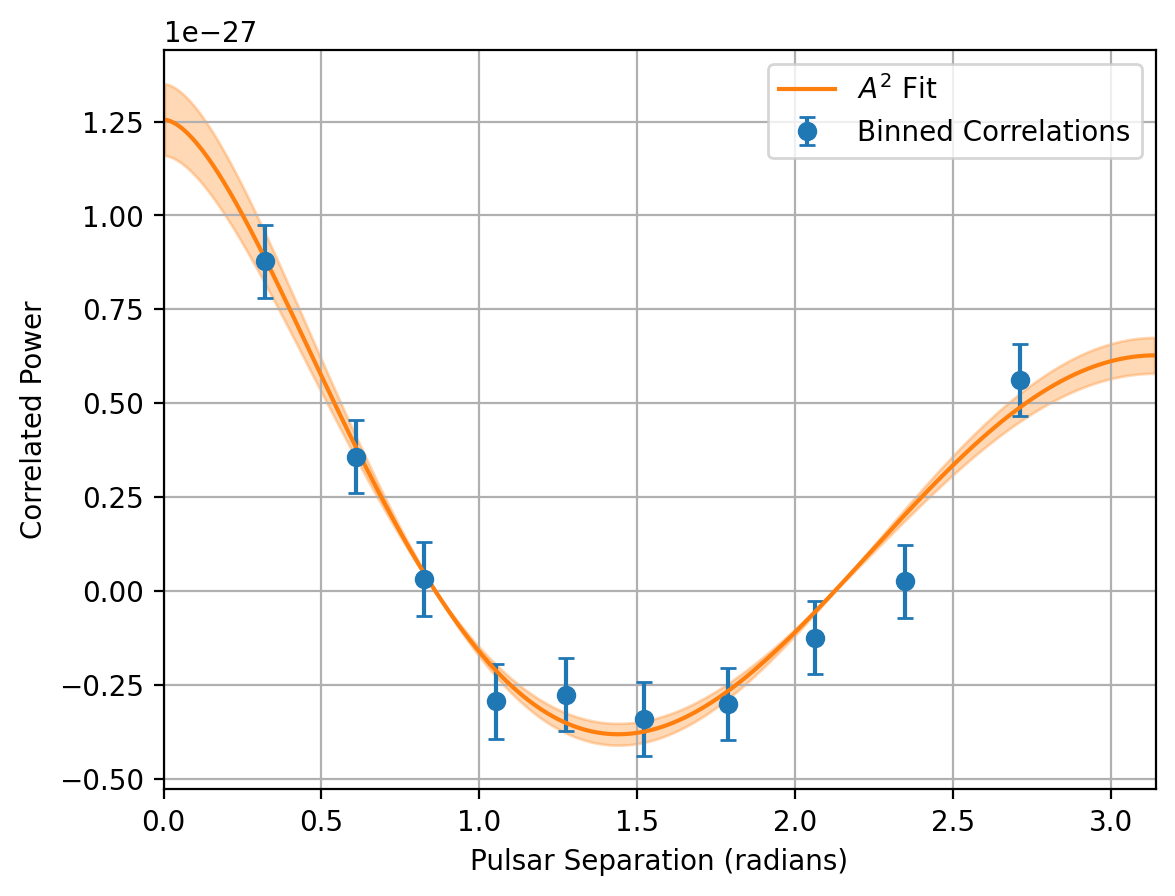

In [5]:
os_obj.set_orf(['hd'])
out = os_obj.compute_OS(params=inj_params)
xi,rho,sig,C,A2,A2s,idx = (out[k] for k in ['xi','rho','sig','C','A2','A2s','idx'])

defplot.create_correlation_plot(xi,rho,sig,C,A2,A2s,bins=10);
print("The recovered amplitude is:",np.sqrt(A2),"The injected amplitude is:",10**inj_params['gw_log10_A'])
print("The SNR is:",A2/A2s)

# Phase shifting

This method employs the phase shifting strategy detailed in III.A of Taylor et al. 2017. The goal with this strategy is to take each pulsar's signal data in each frequency and add a phase shift on the response matrix $F_{ak}$ by a uniform random phase, $\phi_{ak}$ where a is the pulsar and k is the frequency. This can be accomplished elegantly in the rank-reduced form of the OS,
$$ \rho_{ab} = \frac{X_a^T \hat{\phi} X_b}{\rm{tr}(Z_a \hat{\phi} Z_b \hat{\phi})} $$

In this form, the pair-wise correlated amplitudes, X represents a (sort-of but not quite true) representation of a vector of the fourier components of the GWB amplitudes in each frequency's sine component and cosine component with shape $[2N_{freq} \times 1]$. i.e. $X_a \propto [h_{f_1,sine}, h_{f_1,cosine}, h_{f_2,sine}, h_{f_2,cosine}, ... ]$ where $h_{f_k,mode}$ is the GWB amplitude in that frequency and mode. Similarly, $Z_a$ can be thought of as the fourier-domain representation of the TOA covariance matrix for pulsar a, and has the same form as $X_a$ in that it contains both the sines and cosines for each frequency. The big difference is that, as a covariance matrix, $Z_a$ is of shape $[2N_{freq} \times 2N_{freq}]$

Since phase shifting in this bases is simply exchanging power between and individual frequency's modes, we can employ a clever trick to do this through the use of rotation matrices. Consider a rotation matrix $R_{ak}$ which can be defined as,
$$ R_{ak} = 
\begin{bmatrix}
    cos\phi & -sin\phi \\
    sin\phi & cos\phi
\end{bmatrix}
$$

In defining these matrices, we need to ensure that for each pulsar and frequency combination we draw a completely new random phase $\phi = U[0,2\pi]$. Using these, we can construct a larger block diagonal matrix out of these matrices (note that this matrix should have $N_{freq}$ number of blocks)
$$ R_{a} =
\begin{bmatrix}
    R_{a1} & 0 & 0 & \\
    0 & R_{a2} & 0 & \cdots\\
    0 & 0 & R_{a3} & \\
      & \vdots &  & \ddots
\end{bmatrix}
$$

Now we can apply this to our equation which we can then simplify by defining shifted versions of $X'_a = R_a X_a$ and $Z'_a = R^T_a Z_a R_a$:
$$ \rho'_{ab} = 
\frac{(R_a X_a)^T \hat{\phi} (R_b X_b)}{\rm{tr}((R^T_a Z_a R_a) \hat{\phi} (R^T_b Z_b R_b) \hat{\phi})} 
=
\frac{X'^{T}_a \hat{\phi} X'_b}{\rm{tr}(Z'_a \hat{\phi} Z'_b \hat{\phi})} 
$$

So, in order to phase shift our data, we can simply 'rotate' our X and Z matrix products and compute the SNR as normal. Of course, this is all done for you in this function!

### single-component

All of these functions work with both the single-component OS and the multi-component OS. First, lets look at the single component OS and plot the null distribution as well as the measured SNR. As should be obvious, we do not get any null samples even remotely close to the measured value, meaning we can only say that the true P value is less than an upper bound set by the [rule of succesion](https://en.wikipedia.org/wiki/Rule_of_succession) 


shifts: 100%|██████████| 1000/1000 [00:03<00:00, 327.34it/s]


Measured P-value: 0.0 Upper limit: P<= 0.000998003992015968


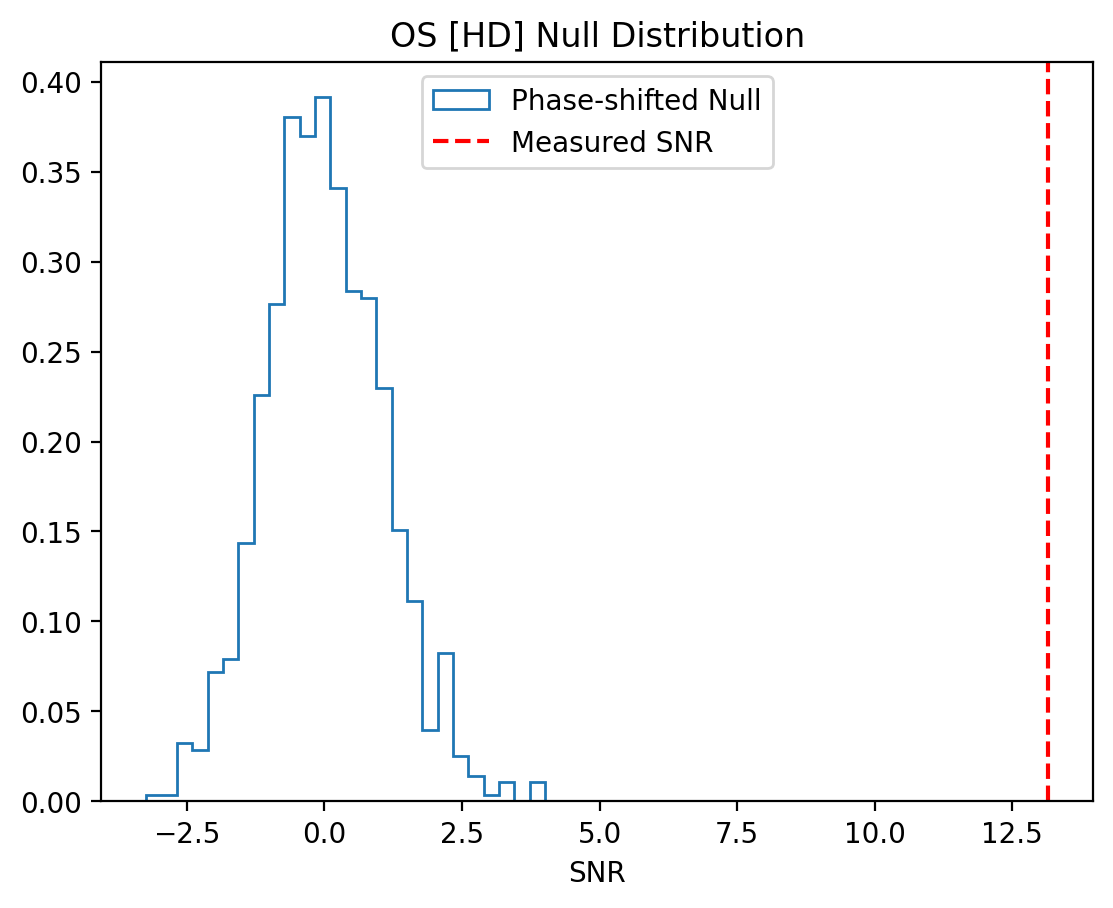

In [6]:
from defiant.null_distribution import phase_shift_OS

os_obj.set_orf(['hd'])
p,snr,n_dist = phase_shift_OS(os_obj,inj_params,n_shifts=1000)

print('Measured P-value:',p,'Upper limit: P<=',1/(len(n_dist)+2))

plt.title('OS [HD] Null Distribution')
plt.hist(n_dist,bins='auto',density=True,histtype='step',label='Phase-shifted Null');
plt.axvline(snr, color='r', linestyle='--',label='Measured SNR')
plt.xlabel('SNR')
plt.legend()
plt.show()

### multi-component

Likewise, we can do this with the multi-component OS. In this case, since our simulated data is completely dominated by HD correlations, the overall plot will not change much, but due to the way we calculate SNR in the multi-component case, you may notice that the null distribution is no longer negative. In the MCOS, we can calculate the total SNR through the equation:
$$ \rm{SNR}^2_{\rm{total}} = \hat{\theta}^T (X^T C^{-1} X) \hat{\theta} = \hat{\theta}^T F \hat{\theta} $$
where $\hat{\theta}$ is the vector of measured amplitudes, X is the overlap reduction function (ORF) design matrix, C is the pair-wise covariance matrix (will be diagonal), and F is the fisher information matrix $F = X^T C^{-1} X$

#### Importantly, this does NOT work with monopole correlations, as phase shifting does not destroy those.


shifts: 100%|██████████| 1000/1000 [00:05<00:00, 170.89it/s]

Measured P-value: 0.0 Upper limit: P<= 0.000998003992015968


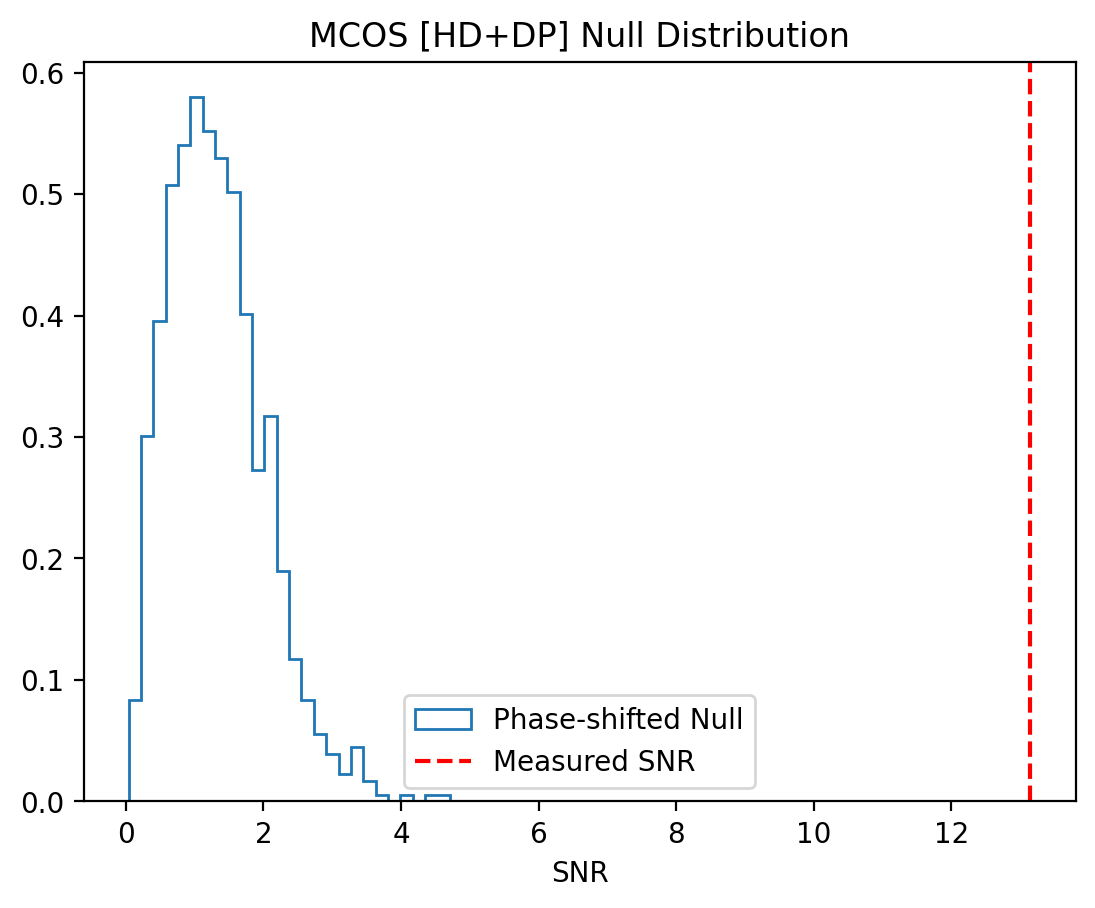

In [7]:
os_obj.set_orf(['hd','dp'])
p,snr,n_dist = phase_shift_OS(os_obj,inj_params,n_shifts=1000)

print('Measured P-value:',p,'Upper limit: P<=',1/(len(n_dist)+2))

plt.title('MCOS [HD+DP] Null Distribution')
plt.hist(n_dist,bins='auto',density=True,histtype='step',label='Phase-shifted Null');
plt.axvline(snr, color='r', linestyle='--',label='Measured SNR')
plt.xlabel('SNR')
plt.legend()
plt.show()

# Sky scrambling

The sky-scrambling method which is first detailed in [Cornish & Sampson 2016](https://arxiv.org/abs/1512.06829) and can also be found in III.B of Taylor et al. 2017. It employs a similar idea as phase shifting. Instead of changing the data to destroy correlations, you can destroy your model. Since we expect non-monopole correlations to be dependent on the pulsar separations, creating a model with the wrong pulsar separations will result in no measurable GWB. 

This method is far simpler to explain as all we need to do is change the places of the pulsars, then re-calculate the overlap reduction function (ORF) design matrix. We do note however that there is an additional toggle for the ```sky_scramble_OS()``` function called ```swap_pos```. This boolean controls the two behaviors of this function:
1. If ```swap_pos=False``` (default): This function will generate new uniformly random positions in the sky for each pulsar then calculate the design matrix. This has the benifit of being an enormous space of PTA configurations which will fairly independent.
2. If ```swap_pos=True```: This function will instead just swap around the pulsar positions between eachother to create new configurations. This has the benifit of having the same set of pulsar separations, but at the cost of a drastically reduced PTA configuration space. 

As with all things, the choice is complicated, and it may be best to just show both methods instead of adopting one.


### single-component

scrambles: 100%|██████████| 1000/1000 [00:02<00:00, 471.08it/s]

Measured P-value: 0.0 Upper limit: P<= 0.000998003992015968


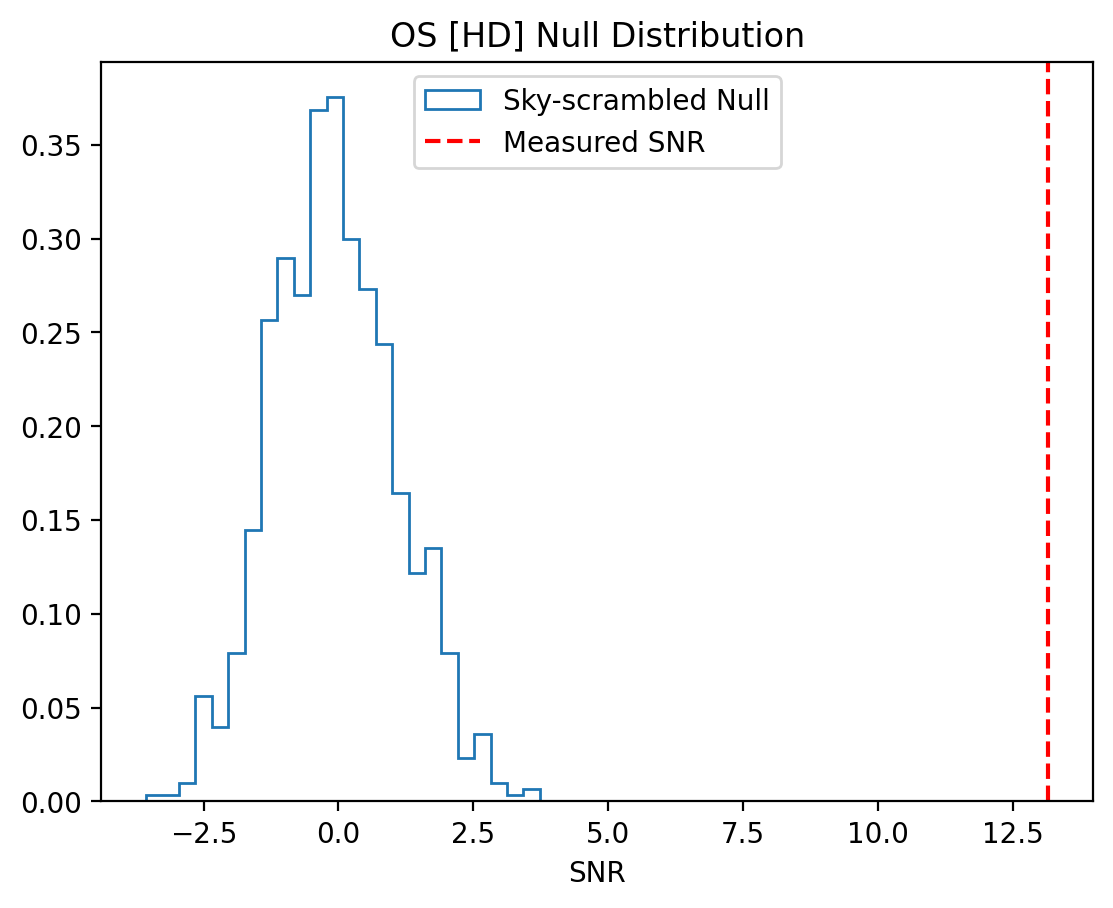

In [8]:
from defiant.null_distribution import sky_scramble_OS

os_obj.set_orf(['hd'])
p,snr,n_dist = sky_scramble_OS(os_obj,inj_params,n_scrambles=1000,swap_pos=False)

print('Measured P-value:',p,'Upper limit: P<=',1/(len(n_dist)+2))

plt.title('OS [HD] Null Distribution')
plt.hist(n_dist,bins='auto',density=True,histtype='step',label='Sky-scrambled Null');
plt.axvline(snr, color='r', linestyle='--',label='Measured SNR')
plt.xlabel('SNR')
plt.legend()
plt.show()

### Check if swapping positions is different than new positions

Let's plot the two forms of sky scrambling here to see the difference. As you can see, the difference is noticable, especially with the more dense tail of the swapping method. However, there may be multiple realizations where the similarities between configurations are high, especially with low numbers of pulsars. 

The total number of configurations is done through permutations $_n P_n = n!$, however, this consists of numerous such configurations in which many of the pulsar positions are the same. Determining the actual independence of these permutations is something we should do to trust this method fully.

scrambles: 100%|██████████| 10000/10000 [00:16<00:00, 615.71it/s]


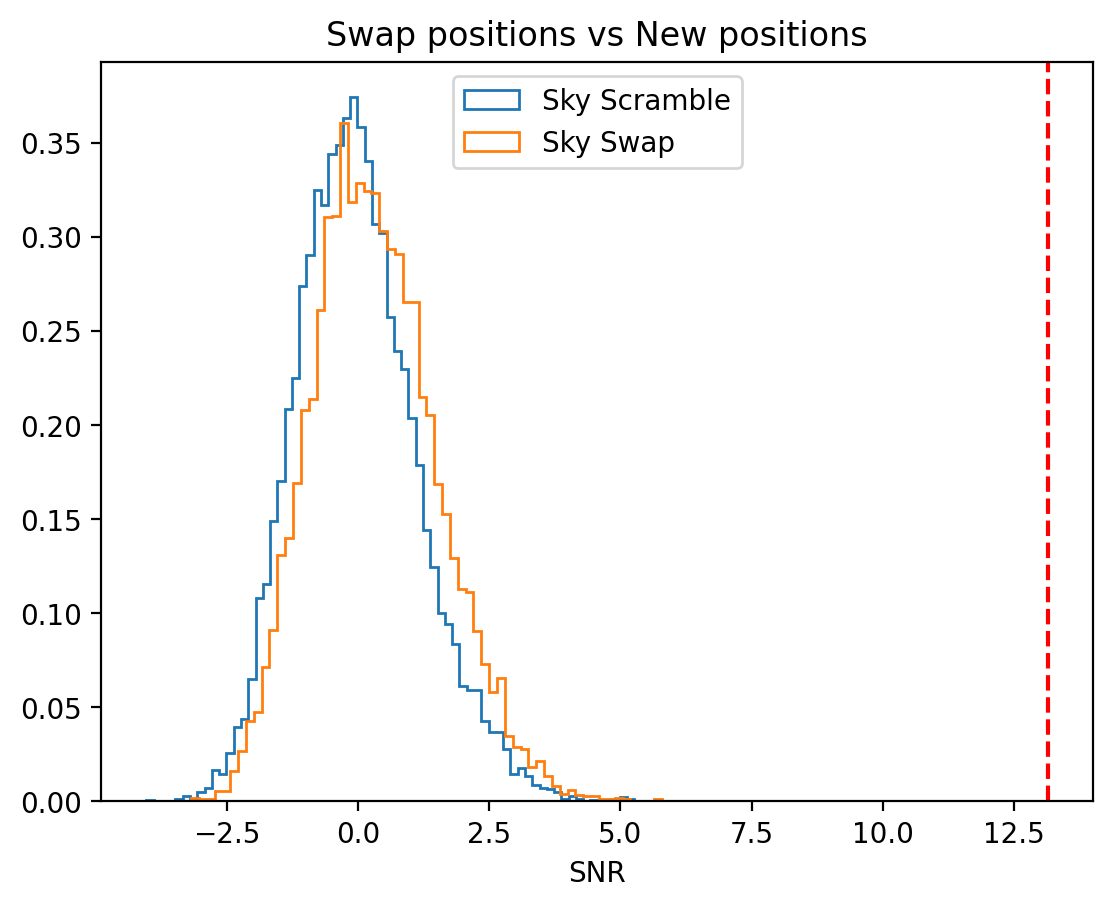

In [9]:
os_obj.set_orf(['hd'])
p,snr,n_dist = sky_scramble_OS(os_obj,inj_params,n_scrambles=int(1e4),swap_pos=False)
_,_,swap_dist = sky_scramble_OS(os_obj,inj_params,n_scrambles=int(1e4),swap_pos=True)

plt.hist(n_dist,bins='auto',histtype='step',label='Sky Scramble',density=True);
plt.hist(swap_dist,bins='auto',histtype='step',label='Sky Swap',density=True);
plt.axvline(snr, color='r', linestyle='--')
plt.legend()
plt.xlabel('SNR')
plt.title('Swap positions vs New positions')
plt.show()

We can also make plots that mimic those of Figure 3 in the [NG15 paper](https://arxiv.org/abs/2306.16213) called extinction plots

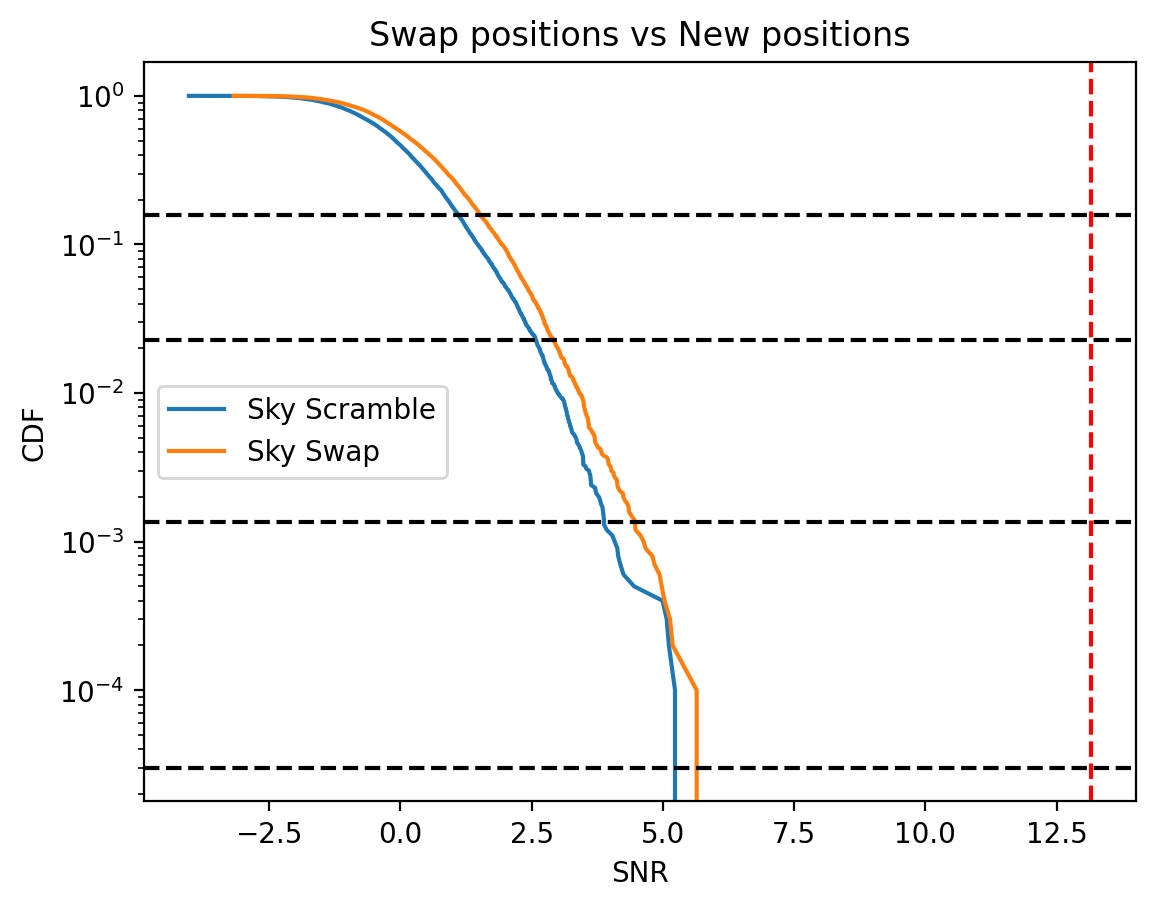

In [10]:
n_dist = np.sort(n_dist)
plt.plot(n_dist,1-np.linspace(0,1,len(n_dist)),label='Sky Scramble')
swap_dist = np.sort(swap_dist)
plt.plot(swap_dist,1-np.linspace(0,1,len(swap_dist)),label='Sky Swap')
plt.axvline(snr, color='r', linestyle='--')

plt.axhline(1-0.84134, color='k', linestyle='--')
plt.axhline(1-0.97725, color='k', linestyle='--')
plt.axhline(1-0.99865, color='k', linestyle='--')
plt.axhline(1-0.99997, color='k', linestyle='--')

plt.legend()
plt.xlabel('SNR')
plt.ylabel('CDF')
plt.title('Swap positions vs New positions')
plt.yscale('log')
plt.show()

### multi-component

Similarly, these methods can be applied to the multi-component OS too

scrambles: 100%|██████████| 1000/1000 [00:04<00:00, 243.46it/s]

Measured P-value: 0.0 Upper limit: P<= 0.000998003992015968


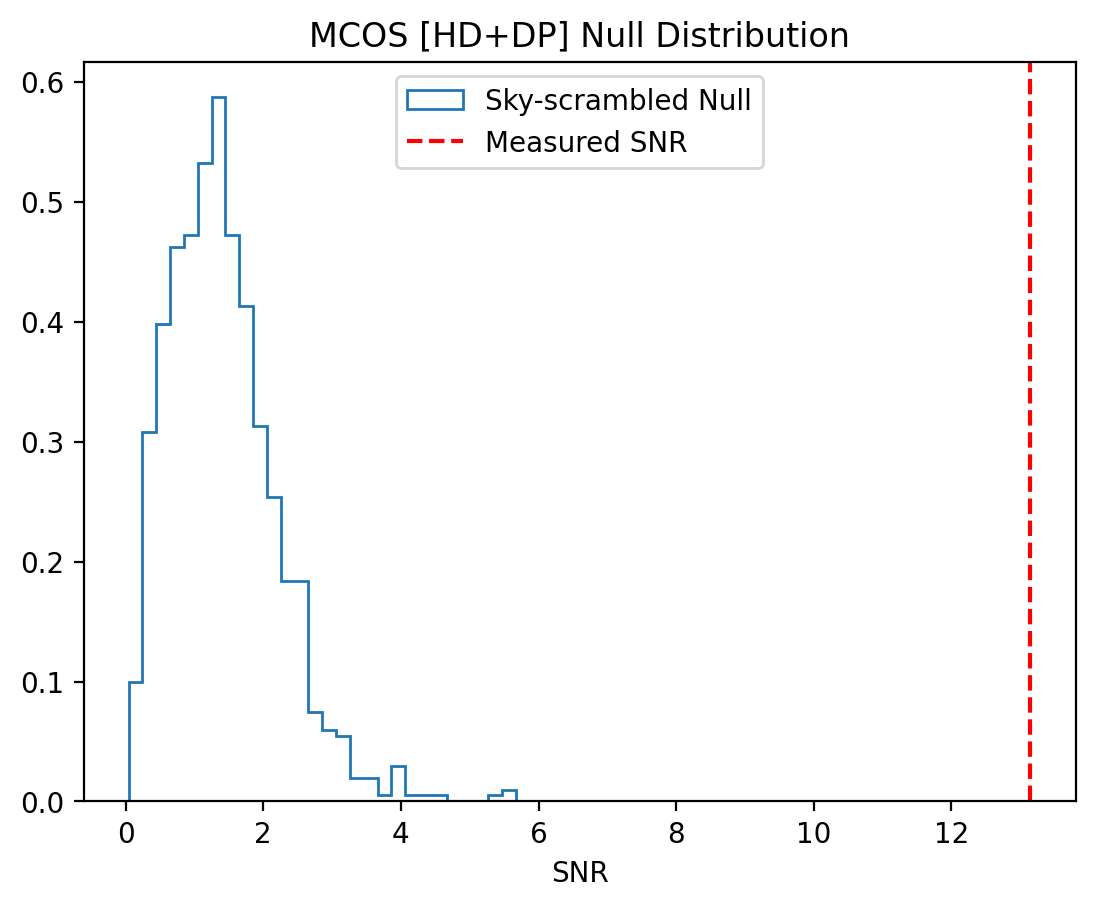

In [11]:
os_obj.set_orf(['hd','dp'])
p,snr,n_dist = sky_scramble_OS(os_obj,inj_params,n_scrambles=1000)

print('Measured P-value:',p,'Upper limit: P<=',1/(len(n_dist)+2))

plt.title('MCOS [HD+DP] Null Distribution')
plt.hist(n_dist,bins='auto',density=True,histtype='step',label='Sky-scrambled Null');
plt.axvline(snr, color='r', linestyle='--',label='Measured SNR')
plt.xlabel('SNR')
plt.legend()
plt.show()

# Super scrambles (phase shift + sky scramble)

Finally, we can also stick these two methods together to form super scrambles. All of the previous wisdom and usage applies to this method, but computation might take a bit longer.

### single-component

s scrambles: 100%|██████████| 1000/1000 [00:04<00:00, 202.14it/s]

Measured P-value: 0.0 Upper limit: P<= 0.000998003992015968


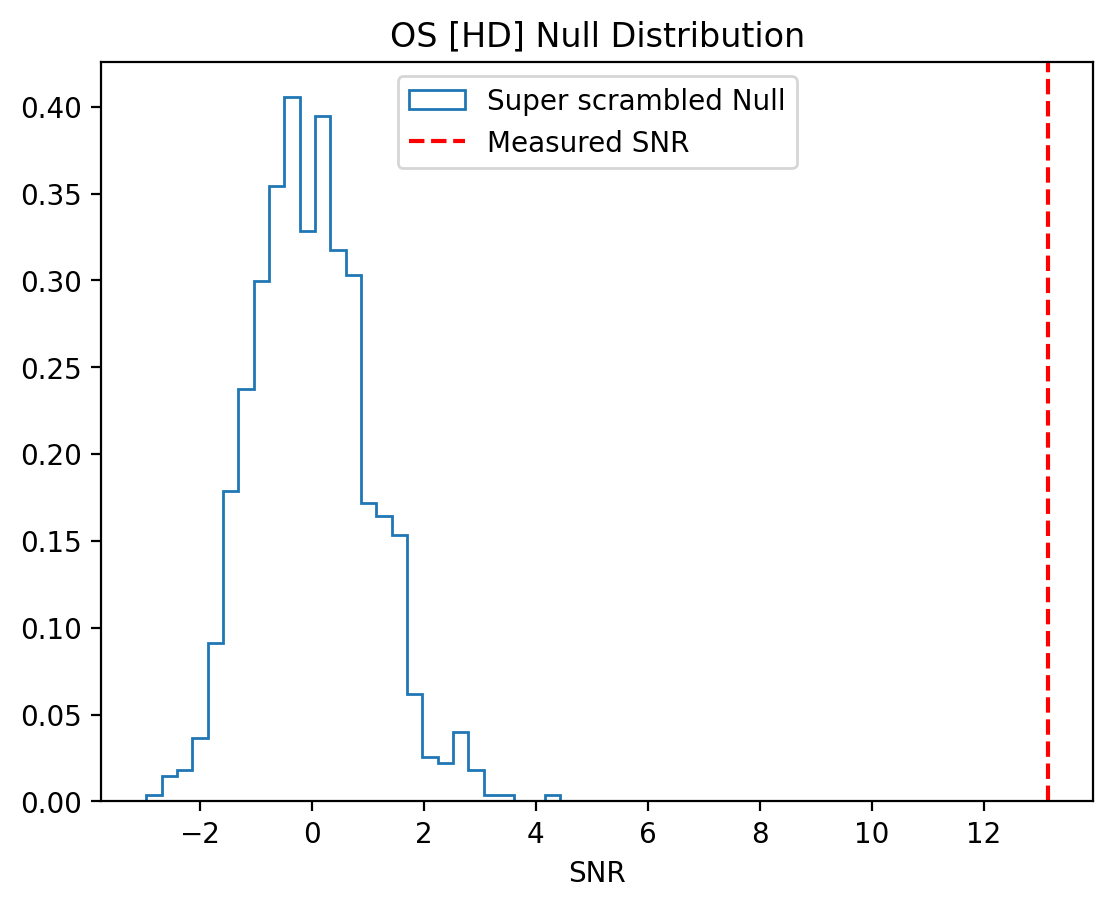

In [12]:
from defiant.null_distribution import super_scramble_OS

os_obj.set_orf(['hd'])
p,snr,n_dist = super_scramble_OS(os_obj, inj_params, n_scrambles=1000)

print('Measured P-value:',p,'Upper limit: P<=',1/(len(n_dist)+2))

plt.title('OS [HD] Null Distribution')
plt.hist(n_dist,bins='auto',density=True,histtype='step',label='Super scrambled Null');
plt.axvline(snr, color='r', linestyle='--',label='Measured SNR')
plt.xlabel('SNR')
plt.legend()
plt.show()

### multi-component

s scrambles: 100%|██████████| 1000/1000 [00:07<00:00, 139.77it/s]


Measured P-value: 0.0 Upper limit: P<= 0.000998003992015968


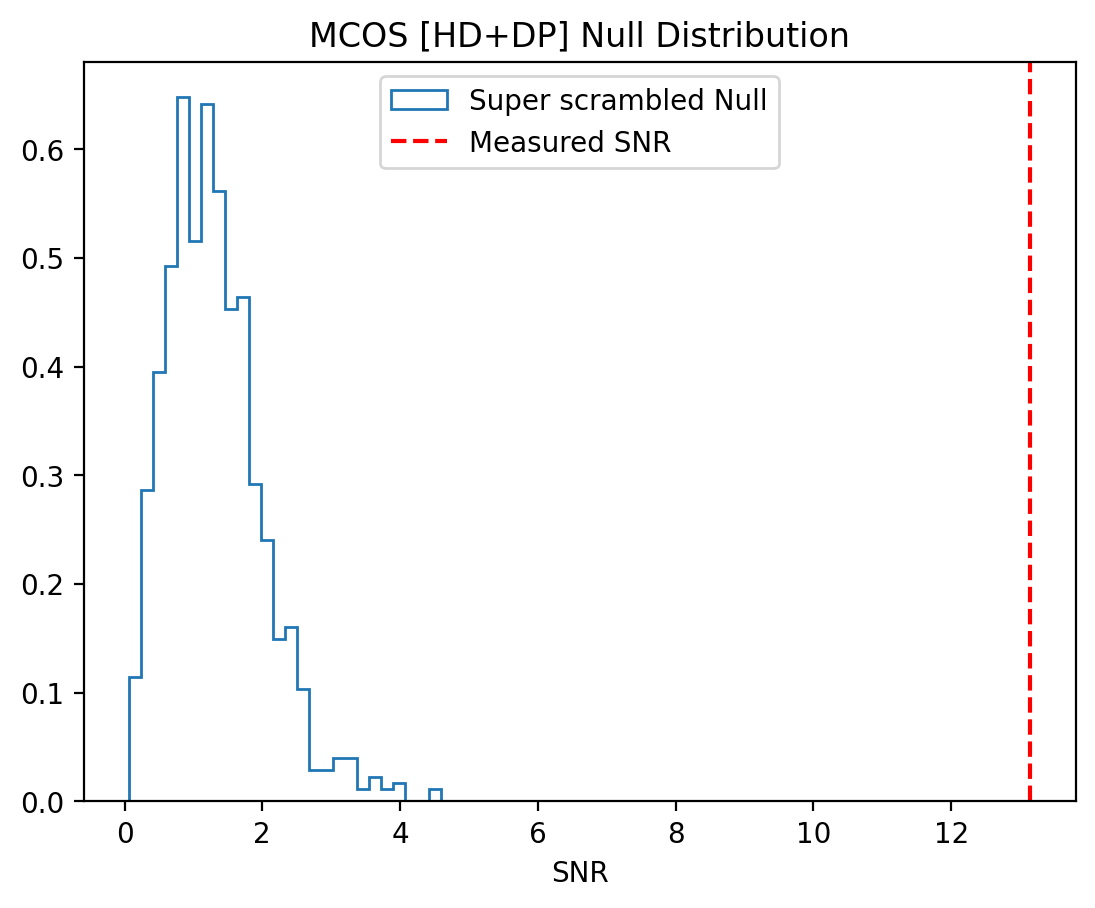

In [13]:
os_obj.set_orf(['hd','dp'])
p,snr,n_dist = super_scramble_OS(os_obj, inj_params, n_scrambles=1000)

print('Measured P-value:',p,'Upper limit: P<=',1/(len(n_dist)+2))

plt.title('MCOS [HD+DP] Null Distribution')
plt.hist(n_dist,bins='auto',density=True,histtype='step',label='Super scrambled Null');
plt.axvline(snr, color='r', linestyle='--',label='Measured SNR')
plt.xlabel('SNR')
plt.legend()
plt.show()